In [13]:
# Импорты

import math
import numpy as np
import pandas as pd
from datetime import date
import seaborn as sns
import matplotlib.pyplot as plt
import itertools
from time import time 

import holidays
import prophet
# from prophet.plot import add_changepoints_to_plot, plot_cross_validation_metrics
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
from sklearn.metrics import mean_absolute_percentage_error


In [14]:
# from google.oauth2 import service_account

# pd.set_option('display.max_columns', 599)
# pd.set_option('display.max_rows', 599)

# project_id = 'kolesa-android-app'
# credentials = 'C:/kolesa-android-app-715adc9bdf26.json'
# credentials = service_account.Credentials.from_service_account_file(credentials)

In [15]:
# q = """SELECT * FROM `kolesa-android-app.academy.time_series_dataset` ORDER BY 1"""

In [16]:
# data = pd.read_gbq(query=q, project_id=project_id, credentials=credentials, dialect='standard', progress_bar_type='tqdm') # Запрос данных из GBQ

In [17]:
#ЕСЛИ У ВАС НЕТ ДОСТУПА К BQ, ТО МОЖНО ЗАГРУЗИТЬ ДАННЫЕ ЧЕРЕЗ CSV

data = pd.read_csv('Data/data.csv')
data

,event_date,y
0,2022-01-19,15360
1,2022-11-08,19712
2,2021-06-07,12801
3,2021-03-28,12801
4,2021-04-15,13314
...,...,...
1091,2022-07-24,15103
1092,2022-02-28,15615
1093,2021-10-31,16383
1094,2021-12-01,16918


In [18]:
data.sort_values(by='event_date', inplace=True)
data

,event_date,y
376,2020-01-01,5721
345,2020-01-02,8274
532,2020-01-03,9344
574,2020-01-04,9864
843,2020-01-05,10435
...,...,...
623,2022-12-27,17042
285,2022-12-28,16195
495,2022-12-29,14966
56,2022-12-30,13070


In [19]:
data.dtypes

event_date    object
y              int64
dtype: object

In [20]:
data['event_date'] = pd.to_datetime(data['event_date'])
data.dtypes

event_date    datetime64[ns]
y                      int64
dtype: object

In [21]:
data.columns = ['ds', 'y']
data.index = pd.to_datetime(data['ds'])
data.head()

,ds,y
ds,,
2020-01-01,2020-01-01,5721
2020-01-02,2020-01-02,8274
2020-01-03,2020-01-03,9344
2020-01-04,2020-01-04,9864
2020-01-05,2020-01-05,10435


<Axes: xlabel='ds'>

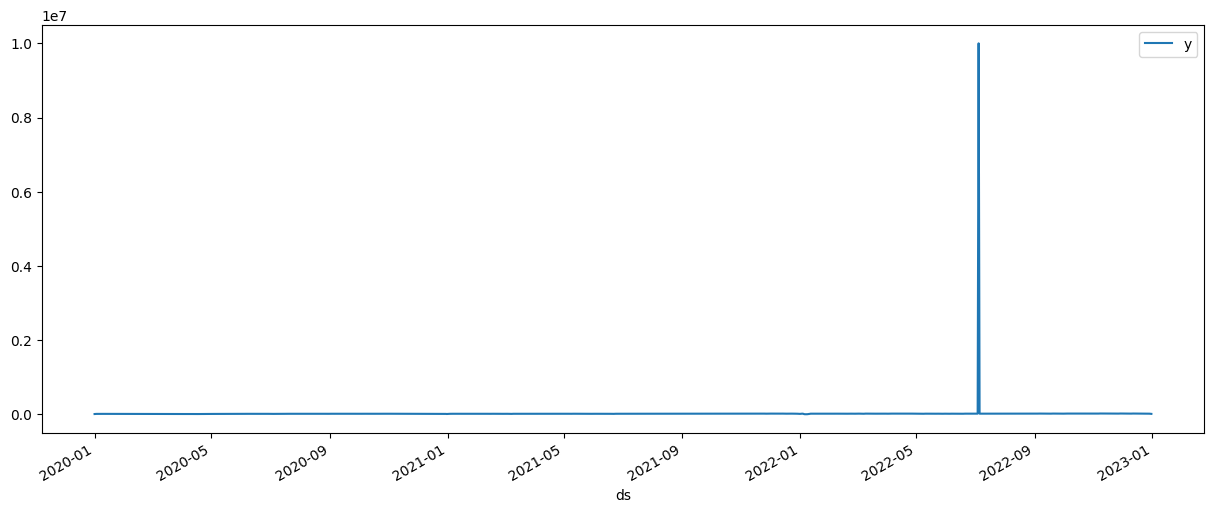

In [22]:
data.plot(x = 'ds', y = 'y', figsize=(15, 6))

In [23]:
data.idxmax()

ds   2022-12-31
y    2022-07-05
dtype: datetime64[ns]

In [24]:
data.loc[data['y'].idxmax(), 'y'] = data['y'].mean()

C:\Users\lofas\AppData\Local\Temp\ipykernel_17248\1973940019.py:1: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '22644.69708029197' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  data.loc[data['y'].idxmax(), 'y'] = data['y'].mean()


<Axes: xlabel='ds'>

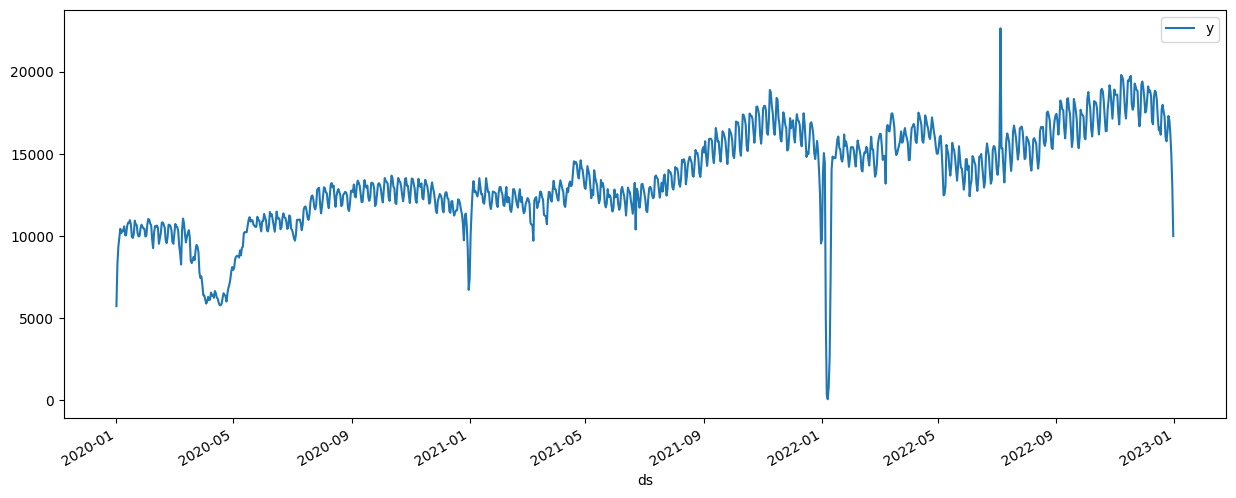

In [25]:
data.plot(x = 'ds', y = 'y', figsize=(15, 6))

In [26]:
for i in range(5):
    data.loc[data['y'].idxmin(), 'y'] = data['y'].mean()

<Axes: xlabel='ds'>

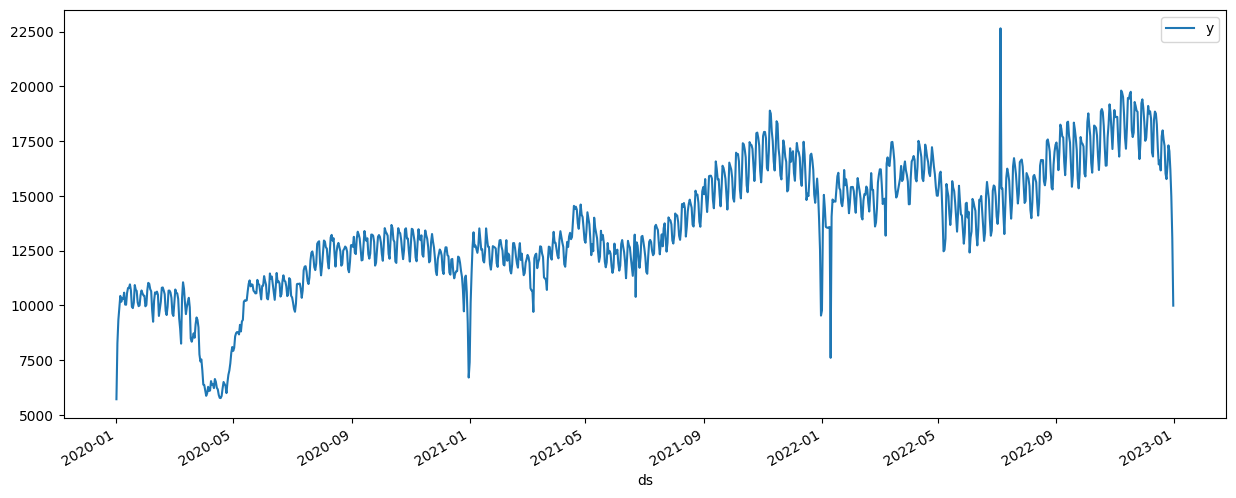

In [27]:
data.plot(x = 'ds', y = 'y', figsize=(15, 6))

In [28]:
def is_ramadan(ds):
    date = pd.to_datetime(ds)
    return ((date >=pd.to_datetime('2020-04-24')) & (date <= pd.to_datetime('2020-05-24'))
            | (date >=pd.to_datetime('2021-04-13')) & (date <= pd.to_datetime('2021-05-13'))
            | (date >=pd.to_datetime('2022-04-03')) & (date <= pd.to_datetime('2022-05-03')))

data['is_ramadan'] = data['ds'].apply(is_ramadan)
data['ramadan'] = data['is_ramadan'].apply(int)
data.head()
    

,ds,y,is_ramadan,ramadan
ds,,,,
2020-01-01,2020-01-01,5721.0,False,0
2020-01-02,2020-01-02,8274.0,False,0
2020-01-03,2020-01-03,9344.0,False,0
2020-01-04,2020-01-04,9864.0,False,0
2020-01-05,2020-01-05,10435.0,False,0


In [29]:
holidays_kz = holidays.KZ(years = (2020, 2021, 2022, 2023))
df_holidays = pd.DataFrame.from_dict(holidays_kz, orient='index').rename(columns={0: 'holiday'})
df_holidays['ds'] = df_holidays.index
# df_holidays.index = df_holidays['ds']
df_holidays.head()

,holiday,ds
2020-01-01,New Year,2020-01-01
2020-01-02,New Year,2020-01-02
2020-01-07,Orthodox Christmas,2020-01-07
2020-03-08,International Women's Day,2020-03-08
2020-03-22,Nauryz holiday,2020-03-22


In [30]:
from prophet.plot import add_changepoints_to_plot
def get_mape(model, actual=data):
    return mean_absolute_percentage_error(actual['y'], model.predict(actual)['yhat'])

def plot(model, actual=data, threshold_changepoints=0.01):
    df_pred = model.predict(actual)
    df_pred.index = df_pred.ds
    df_plot = pd.concat([actual, df_pred], axis=1)
    ax = df_plot[:].plot(y=["y", "yhat"], kind = "line", figsize=(10, 10))
    a = add_changepoints_to_plot(ax, model, df_pred, threshold = threshold_changepoints)

In [31]:
initial = str(int(data.shape[0]/2)) + ' days'
horizon = str(int(data.shape[0]/20)) + ' days'
period = str(int(data.shape[0]/20)) + ' days'
print('initial:', initial) 
print('horizon:', horizon)
print('period:', period)

initial: 548 days
horizon: 54 days
period: 54 days


22:42:36 - cmdstanpy - INFO - Chain [1] start processing
22:42:39 - cmdstanpy - INFO - Chain [1] done processing


('MAPE: ', 0.10176769750189026)

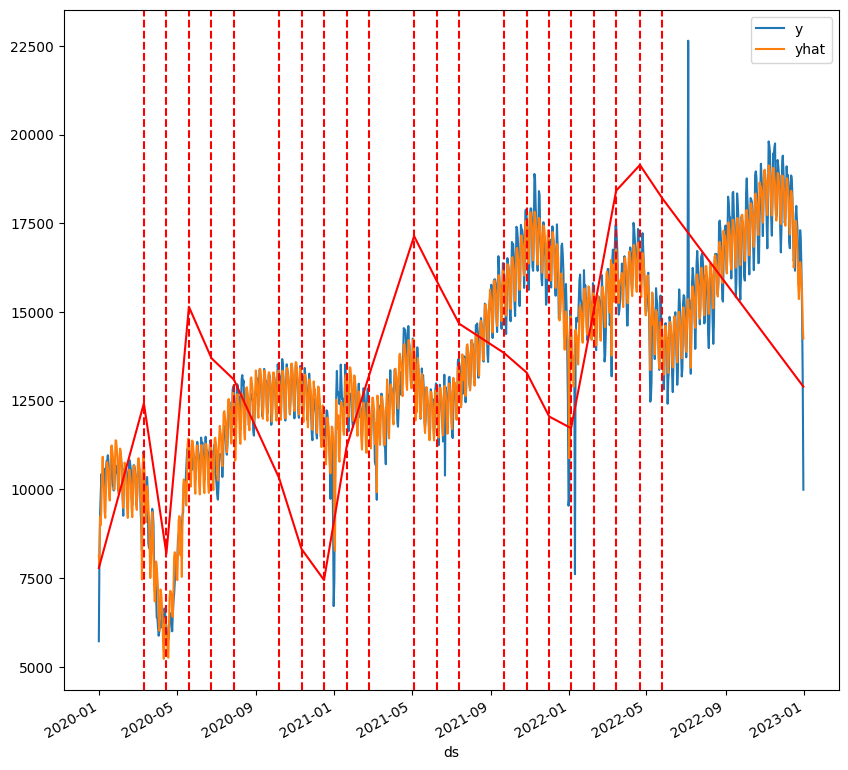

In [32]:
model = Prophet(changepoint_prior_scale=0.9, holidays = df_holidays)

model.fit(data)

cv_results = cross_validation(
    model, 
    initial=initial, 
    horizon=horizon, 
    period=period,
    parallel="processes"
)
plot(model)
'MAPE: ', np.average(performance_metrics(cv_results).mape.values)

22:42:54 - cmdstanpy - INFO - Chain [1] start processing
22:42:55 - cmdstanpy - INFO - Chain [1] done processing


('MAPE: ', 0.08830554895076226)

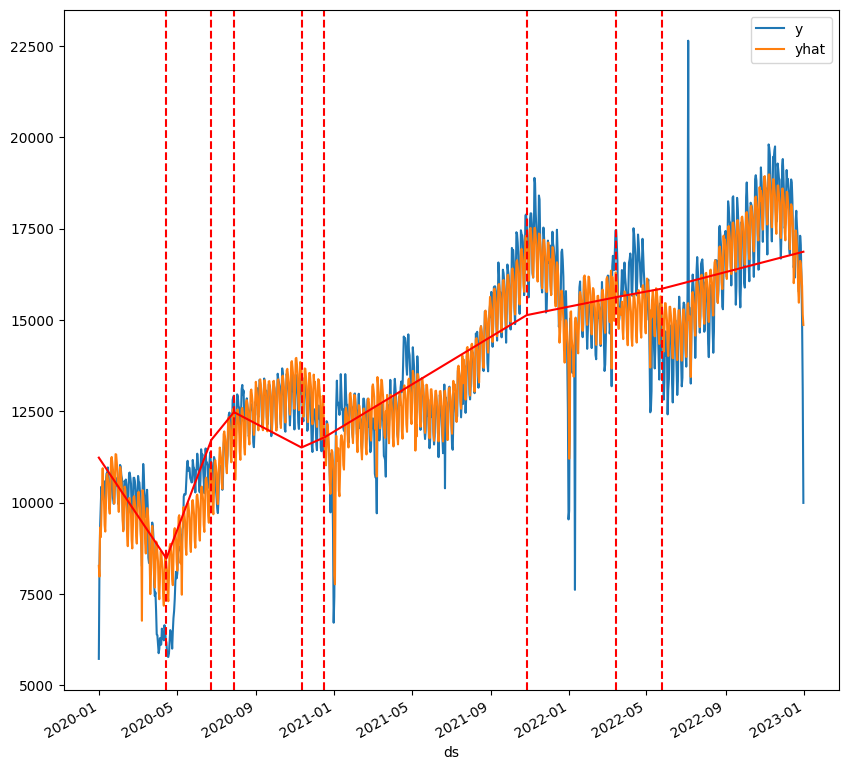

In [33]:
model = Prophet(holidays=df_holidays, changepoint_range=0.8, )

model.fit(data)
cv_results = cross_validation(
    model, 
    initial=initial, 
    horizon=horizon, 
    period=period,
    parallel="processes"
)
plot(model)
'MAPE: ', np.average(performance_metrics(cv_results).mape.values)

In [34]:
param_grid = {
    'changepoint_prior_scale': np.logspace(0, 10, 5, base = 500**(1/10))/1000,
    'seasonality_prior_scale': np.logspace(0, 10, 5, base = 100**(1/10))/10,
    'holidays_prior_scale': np.logspace(0, 10, 5, base = 100**(1/10))/10,
    'seasonality_mode': ['additive', 'multiplicative'],
}

all_params = [dict(zip(param_grid.keys(), values)) for values in itertools.product(*param_grid.values())]

In [35]:
def train(params): 
    model = Prophet(changepoint_range=0.8,
                    holidays = df_holidays,
                    **params).add_regressor('ramadan')
    
    model.fit(data)
    cv_results = cross_validation(
        model, 
        initial=initial, 
        horizon=horizon, 
        period=period,
        parallel="processes"
    )

    return np.average(performance_metrics(cv_results).mape.values)


In [36]:
mapes = []

print(len(all_params))

start_time = time()
for params in all_params:
    mapes.append(train(params))

print('Time elapsed:', time() - start_time)
best_params = all_params[np.argmin(mapes)]
'MAPE:', min(mapes) 

250


22:43:04 - cmdstanpy - INFO - Chain [1] start processing
22:43:04 - cmdstanpy - INFO - Chain [1] done processing
22:43:04 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
22:43:04 - cmdstanpy - INFO - Chain [1] start processing
22:43:12 - cmdstanpy - INFO - Chain [1] done processing
22:43:19 - cmdstanpy - INFO - Chain [1] start processing
22:43:19 - cmdstanpy - INFO - Chain [1] done processing
22:43:19 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
22:43:19 - cmdstanpy - INFO - Chain [1] start processing
22:43:26 - cmdstanpy - INFO - Chain [1] done processing
22:43:32 - cmdstanpy - INFO - Chain [1] start processing
22:43:32 - cmdstanpy - INFO - Chain [1] done processing
22:43:33 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abn

Time elapsed: 2283.037317276001


('MAPE:', 0.06864451696352813)

In [37]:
print(best_params)

{'changepoint_prior_scale': 0.10573712634405641, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 0.316227766016838, 'seasonality_mode': 'additive'}


In [38]:
# from prophet.plot import plot_cross_validation_metrics

# print('Avarage MAPE: ', np.average(performance_metrics(cv_results).mape.values))
# plot_cross_validation_metrics(cv_results, metric='mape')

23:21:08 - cmdstanpy - INFO - Chain [1] start processing
23:21:08 - cmdstanpy - INFO - Chain [1] done processing


('MAPE: ', 0.07063006557368758)

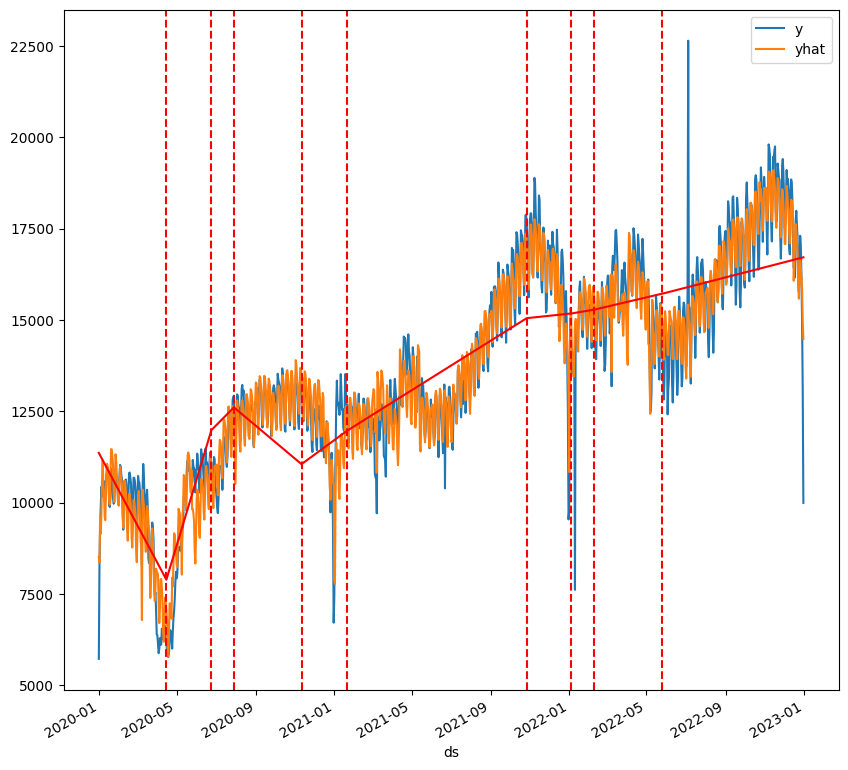

In [39]:
model = Prophet(holidays=df_holidays, changepoint_range=0.8, 
                **best_params).add_regressor('ramadan')
model.add_seasonality(name='monthly_season', period=30.5, fourier_order=7)

model.fit(data)
cv_results = cross_validation(
    model, 
    initial=initial, 
    horizon=horizon, 
    period=period,
    parallel="processes"
)
plot(model)
'MAPE: ', np.average(performance_metrics(cv_results).mape.values)

c:\repos\Kolesa-python-exam\venv\Lib\site-packages\prophet\plot.py:228: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
c:\repos\Kolesa-python-exam\venv\Lib\site-packages\prophet\plot.py:351: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  df_y['ds'].dt.to_pydatetime(), seas[name], ls='-', c='#0072B2')
c:\repos\Kolesa-python-exam\venv\Lib\site-packages\prophet\plot.py:354: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain th

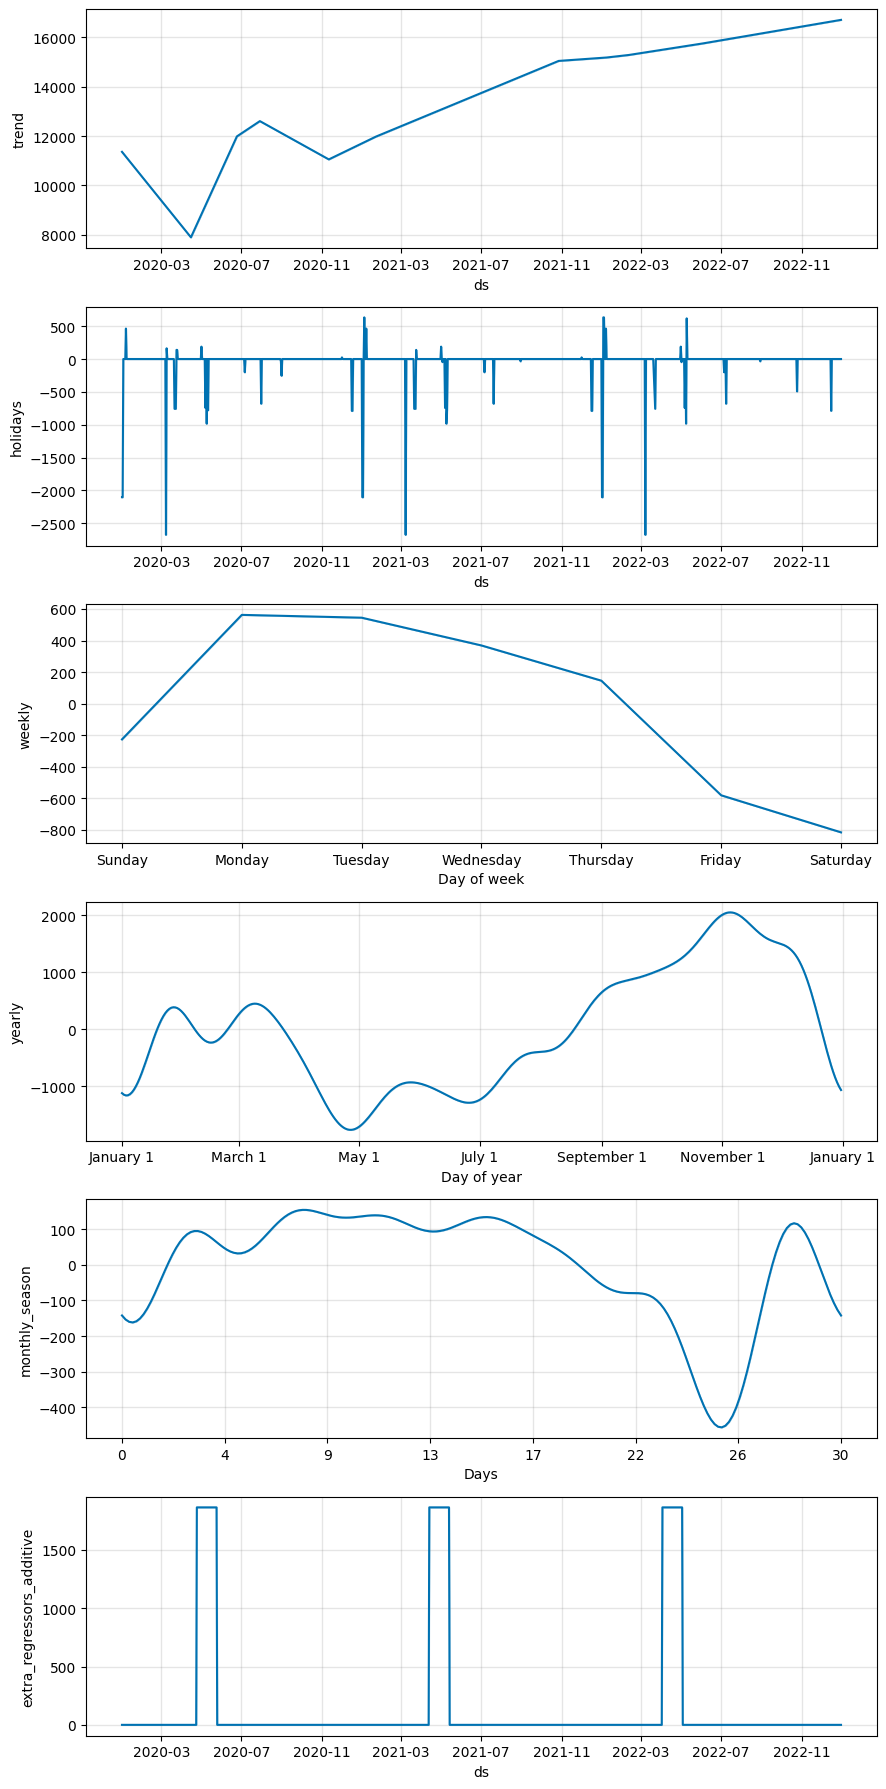

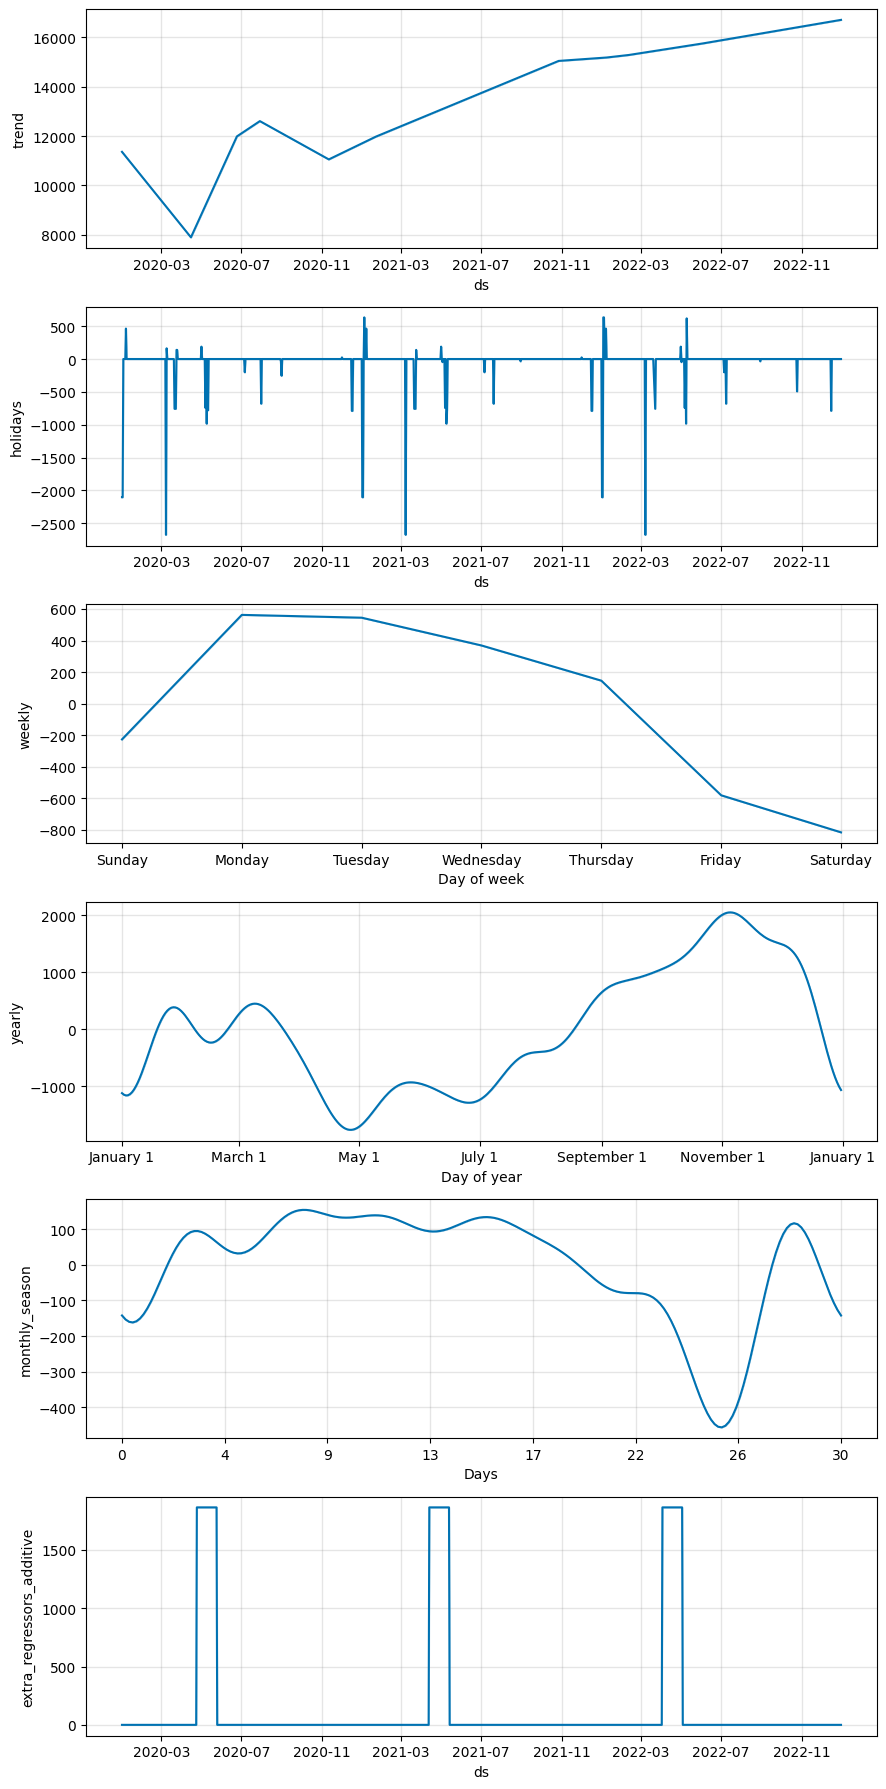

In [40]:
model.plot_components(model.predict(data))

In [41]:
train = data[:-int(data.shape[0]/20)]
test = data[-int(data.shape[0]/20):]
test = test.drop('ds',axis=1)
test = test.reset_index()

In [42]:
model = Prophet(holidays=df_holidays, changepoint_range=0.8, 
                **best_params).add_regressor('ramadan')
model.add_seasonality(name='monthly_season', period=30.5, fourier_order=7)

In [43]:
model.fit(train)

23:21:17 - cmdstanpy - INFO - Chain [1] start processing
23:21:18 - cmdstanpy - INFO - Chain [1] done processing


In [44]:
predict_data = model.make_future_dataframe(test.shape[0], include_history=False)

In [45]:
predict_data = predict_data.merge(test, on='ds', how='left')

In [46]:
predict_data = model.predict(predict_data)

In [47]:
predict_data

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,Capital Day,Capital Day_lower,Capital Day_upper,Constitution Day of the Republic of Kazakhstan,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2022-11-08,16307.059602,17816.445515,19706.335482,16307.059602,16307.059602,0.0,0.0,0.0,0.0,...,520.639903,520.639903,520.639903,1897.796489,1897.796489,1897.796489,0.0,0.0,0.0,18727.853087
1,2022-11-09,16310.437693,17755.478208,19518.550632,16310.437693,16310.437693,0.0,0.0,0.0,0.0,...,345.868367,345.868367,345.868367,1870.174787,1870.174787,1870.174787,0.0,0.0,0.0,18623.497775
2,2022-11-10,16313.815784,17397.719831,19250.009798,16313.815784,16313.815784,0.0,0.0,0.0,0.0,...,140.985658,140.985658,140.985658,1838.452303,1838.452303,1838.452303,0.0,0.0,0.0,18350.502370
3,2022-11-11,16317.193875,16623.753967,18442.819140,16317.193875,16317.193875,0.0,0.0,0.0,0.0,...,-560.869588,-560.869588,-560.869588,1803.126052,1803.126052,1803.126052,0.0,0.0,0.0,17573.283501
4,2022-11-12,16320.571966,16482.994237,18333.014655,16320.571966,16320.571966,0.0,0.0,0.0,0.0,...,-773.894909,-773.894909,-773.894909,1764.760460,1764.760460,1764.760460,0.0,0.0,0.0,17378.019996
5,2022-11-13,16323.950058,17014.854396,18817.526352,16323.950058,16323.950058,0.0,0.0,0.0,0.0,...,-219.055687,-219.055687,-219.055687,1723.974650,1723.974650,1723.974650,0.0,0.0,0.0,17971.973247
6,2022-11-14,16327.328149,17782.814857,19605.411149,16327.328149,16327.328149,0.0,0.0,0.0,0.0,...,546.326258,546.326258,546.326258,1681.427811,1681.427811,1681.427811,0.0,0.0,0.0,18701.036660
7,2022-11-15,16330.706240,17695.904104,19575.978286,16330.706240,16330.706240,0.0,0.0,0.0,0.0,...,520.639903,520.639903,520.639903,1637.802989,1637.802989,1637.802989,0.0,0.0,0.0,18593.994952
8,2022-11-16,16334.084331,17394.657449,19259.238350,16332.561988,16334.084331,0.0,0.0,0.0,0.0,...,345.868367,345.868367,345.868367,1593.789685,1593.789685,1593.789685,0.0,0.0,0.0,18371.745964
9,2022-11-17,16337.462422,17288.496890,19045.606972,16331.351994,16337.462422,0.0,0.0,0.0,0.0,...,140.985658,140.985658,140.985658,1550.065703,1550.065703,1550.065703,0.0,0.0,0.0,18145.758731


In [48]:
mean_absolute_percentage_error(test['y'], predict_data['yhat'])

0.04747505509424941

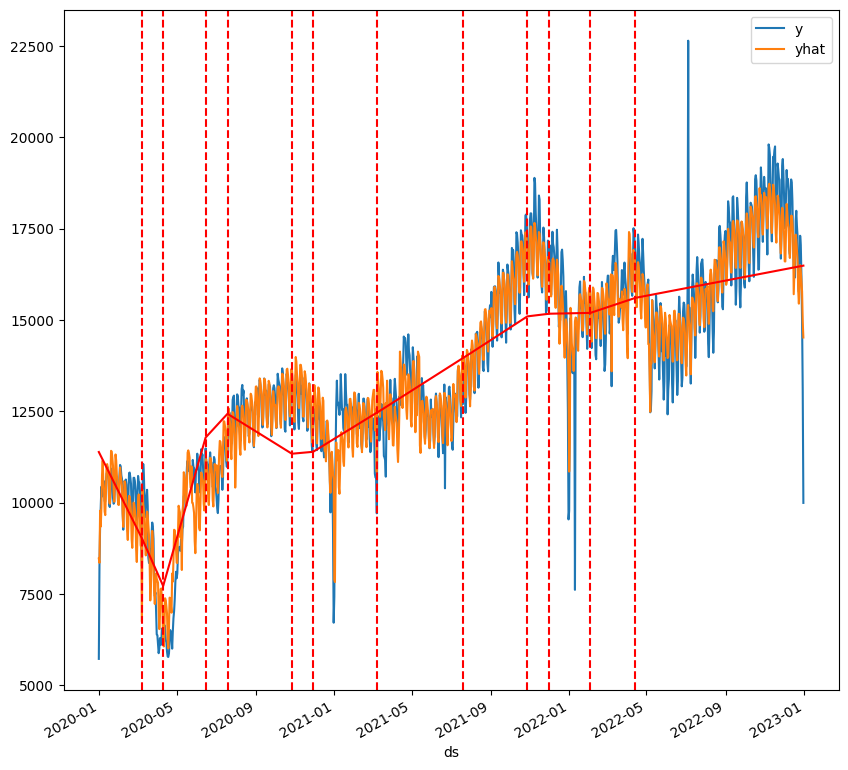

In [49]:
plot(model)

<Axes: >

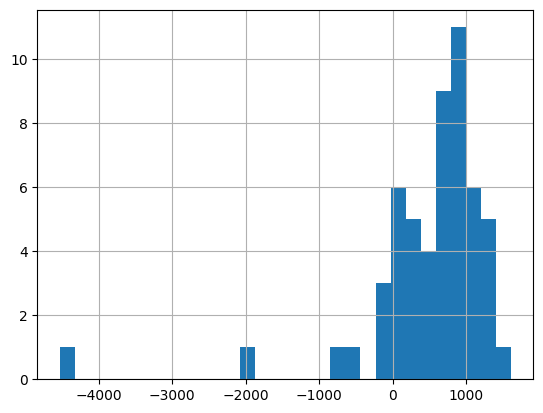

In [52]:
(test['y'] - predict_data['yhat']).hist(bins=30)

In [53]:
np.mean(test['y'] - predict_data['yhat'])

478.39123034104733